[View in Colaboratory](https://colab.research.google.com/github/restrepo/ComputationalMethods/blob/master/material/numerical-calculus-integration.ipynb)

# Numerical Calculus. Integration

Throughout this section and the next ones, we shall cover the topic of numerical calculus. Calculus has been identified since ancient times as a powerful toolkit for analysing and handling geometrical problems. Since differential calculus was developed by Newton and Leibniz (in its actual notation), many different applications have been found, at the point that most of the current science is founded on it (e.g. differential and integral equations). Due to the ever increasing complexity of analytical expressions used in physics and astronomy, their usage becomes more and more impractical, and numerical approaches are more than necessary when one wants to go deeper. This issue has been identified since long ago and many numerical techniques have been developed. We shall cover only the most basic schemes, but also providing a basis for more formal approaches.

From [7 (Chapter 18)](http://pages.cs.wisc.edu/~amos/412/lecture-notes/lecture18.pdf)
> We can only find anti-derivatives for a very small number of functions, such as those functions that are popular as problems in mathematics textbooks. Outside of math classes, these functions are rare 


- - -
- [Numerical Differentiation](./numerical-calculus.ipynb) 
- [Numerical Integration](#Numerical-Integration)
    - [Numerical quadrature](#Numerical-quadrature)
    - [Trapezoidal rule](#Trapezoidal-rule)
    - [Simpson's rule](#Simpson's-rule)
- [Composite Numerical Integration](#Composite-Numerical-Integration)
    - [Composite trapezoidal rule](#Composite-trapezoidal-rule)
    - [Composite Simpson's rule](#Composite-Simpson's-rule)
- [Adaptive Quadrature Methods](#Adaptive-Quadrature-Methods)
    - [Simpson's adaptive quadrature](#Simpson's-adaptive-quadrature)
    - [Steps Simpson's adaptive quadrature](#Steps-Simpson's-adaptive-quadrature)
- [Improper Integrals](#Improper-Integrals)
    - [Left endpoint singularity](#Left-endpoint-singularity)
    - [Right endpoint singularity](#Right-endpoint-singularity)
    - [Infinite singularity](#Infinite-singularity)
    
- - -

In [1]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
# JSAnimation import available at https://github.com/jakevdp/JSAnimationfrom JSAnimation import IPython_display
#from matplotlib import animation
#Interpolation add-on
import scipy.interpolate as interpolate
import scipy.integrate as integrate

Populating the interactive namespace from numpy and matplotlib


# Numerical Integration

Integration is the second fundamental concept of calculus (along with differentiation). Numerical approaches are generally more useful here than in differentiation as the antiderivative procedure (analytically) is often much more complex, or even not possible. In this section we will cover some basic schemes, including numerical quadratures.

Geometrically, integration can be understood as the area below a funtion within a given interval. Formally, given a function $f(x)$ such that $f\in C^{1}[a,b]$, the antiderivative is defined as

$$F(x) = \int f(x) dx$$

valid for all $x$ in $[a,b]$. However, a more useful expression is a definite integral, where the antiderivative is evaluated within some interval, i.e.

$$F(b) - F(a) = \int_{a}^{b} f(x) dx$$

This procedure can be formally thought as a generalization of discrete weighted summation. This idea will be exploited below and will lead us to some first approximations to integration.

See pag. 66 of [PDF](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZmlzaWNhLnVkZWEuZWR1LmNvfGNvbXB1dGFkb3Jlcy1lbi1maXNpY2EtMjAxMC0yfGd4OjFmMDJjN2NlOTc3YWE0YTQ)

From now on we will use the mathemarical functions as defined by SciPy.

In [0]:
import math as m
import cmath as cm
import numpy as np
import scipy as sp

In [0]:
z=2+3.2j

In [0]:
z.real,z.imag,z.conjugate()

(2.0, 3.2, (2-3.2j))

In [0]:
z+3*z

(8+12.8j)

In [0]:
z*z

(-6.240000000000002+12.8j)

In [0]:
z*z.conjugate()

(14.240000000000002+0j)

In [0]:
m.asin(2+0j)

TypeError: can't convert complex to float

In [0]:
cm.asin(2)

(1.5707963267948966+1.3169578969248166j)

In [0]:
np.arcsin(2+0j)

(1.5707963267948966+1.3169578969248166j)

In [0]:
sp.arcsin([2,0.4])

array([1.57079633+1.3169579j, 0.41151685+0.j       ])

## Numpy abstractions
The programming paradigm with Numpy are the abstractions, where the algorithms are written in terms of operations with arrays, avoiding the use of  programming loops. Low level operations between arrays are implemented in C/Fortran within Numpy. Therefore, a code with abstractions is automatically optimized.

Consider for example the numerical integration with the trapezoidal method

![Credit Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Integration_rectangle.svg/300px-Integration_rectangle.svg.png) <small>[See Wikipedia](https://en.wikipedia.org/wiki/Numerical_integration#Methods_for_one-dimensional_integrals)</small>

Wehere for each internval between $x_i$ and $x_{i+1}$, the average height of the function 
$$\frac{f(x_i)+f(x_{i-1})}{2}\,,$$
is used. Therefore
\begin{align*}
  \int_a^b f(x)d x\approx \frac{1}{2}\sum_{i=1}^n (x_i-x_{i-1})(f(x_i)+f(x_{i-1}))\,.
\end{align*}

To implement the correspponding abstractions in Numpy it is convenient to define the following vectors
\begin{align*}
  \Delta \mathbf{X}&=(x_1-x_0,x_2-x_1,\cdots,x_n-x_{n-1})\\ 
   \langle\mathbf{F}\rangle&=\frac{1}{2}(f(x_1)+f(x_0),f(x_2)+f(x_1),\cdots,f(x_n)+f(x_{n-1}))\,.
\end{align*}
The numerical approximation of the integral with the trapezoidal method is then just the dot product between the two previous vectors
\begin{align*}
   \int_a^b f(x)d x\approx \Delta \mathbf{X}\cdot \langle\mathbf{F}\rangle
\end{align*}

We next present the code with different levels of abstractions. The faster is the first one with the direct implementation of the dot product.

In [0]:
def integracion (f,a,b,n=4,test=0):
  '''Trapezoidal method for the numerical integration  de f entre a y b
     con n intervalos
  '''
  import numpy as np
  x=np.linspace(a,b,n+1)
  y=f(x)
  if test == 0:
    return 0.5*np.dot((x[1:]-x[:-1]),(y[1:]+y[:-1]))
  elif test ==1:
    return 0.5*((x[1:]-x[:-1])*(y[1:]+y[:-1])).sum()
  elif test ==2:
    return 0.5*sum((x[1:]-x[:-1])*(y[1:]+y[:-1]))

## Implementation in scipy

In [0]:
integrate.quad?

###  Usage example

In [0]:
f= lambda x: sp.sin ( x )/ x

Note that:

In [0]:
f(0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

Even so, the full tuple output with result and numerical error is obtained from

In [0]:
import time

In [0]:
s=time.time()
print(integrate.quad(f,0,1))
print(time.time()-s)

(0.9460830703671831, 1.0503632079297089e-14)
0.0006222724914550781


Force output to have only the result by asking for the entry 0 of the output tuple, note the `[0]` at the end:

In [0]:
integrate.quad(f,0,1)[0]

0.9460830703671831

In [0]:
integracion(lambda x: sp.sin ( x )/x,1E-14,1,n=5,test=0)

0.945078780953392

In [0]:
s=time.time()
print(integracion(lambda x: sp.sin ( x )/x,1E-14,1,500,test=2))
print(time.time()-s)

0.9460829699776094
0.002169370651245117


Sinintegrate: 
$$\operatorname{Si}(t)=\int_0^t \frac{\sin x}{x}\, \operatorname{d}x$$

In [0]:
import numpy as np
import scipy as sp
import scipy.integrate as integrate

Sifloat=lambda t: integrate.quad(lambda x:sp.sin(x)/x,0,t)[0]
def Si(x):
    try:
        nn=np.array(x).shape[0]
        f=np.vectorize(Sifloat)
    except IndexError:
        f=Sifloat        
    return f(x)

In [0]:
Si(1)

0.946083070367183

In [0]:
Si([1,2])

array([0.94608307, 1.60541298])

When you write `LaTeX`  in  `matplotlib`, you must be sure that the backslash, '\', is properly interpreted  as the key for `LaTeX` commands. This is accomplished  by writting an `r` before the string declaration. Note the different behaviour of the backslash in the next two cells of code. In the first one `\t` is intepreted as the keyboard key `<TAB>` and `\b` as an empty space, while in the second, with the prefix `r`, it is just a pair of `LaTeX` commands

In [0]:
print('$\tan\beta$')

$	aneta$


In [0]:
print(r'$\tan\beta$')

$\tan\beta$


Populating the interactive namespace from numpy and matplotlib


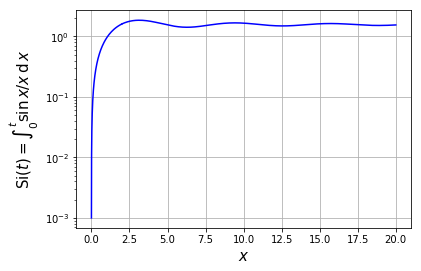

In [0]:
t=np.logspace(np.log10(1E-3),np.log10(2),200)
tt=np.linspace(2,20,200)
plt.semilogy(t,Si(t),'b-')
plt.semilogy(tt,Si(tt),'b-')
plt.xlabel('$x$',size=15)
plt.ylabel(r'${\rm Si}(t)=\int_0^t {\sin\, x}/{x}\,{\rm d}\,x$',size=15)
plt.grid()

## Numerical approximation of integrals

The methods for numerical approximation that we will study here rely in the idea of approximate 
$$\int_a^b f(x)\operatorname{d}x\,,$$
by using some polinomial $p$, such that
$$\int_a^b f(x)\operatorname{d}x\approx \int_a^b P_n(x)\operatorname{d}x\,,$$
The integral of a polynomial can be calculated analytically because we know its antiderivative.

Since, as we seen in [Lagrange-Polynomial](interpolation.ipynb#Lagrange-Polynomial), the next polynomial of $n$th-degree 
$$P_n(x) = \sum_{i=0}^n f(x_i)L_{n,i}(x) = \sum_{i=0}^n y_iL_{n,i}(x)\,,$$
where 
$$L_{n,i}(x) = \prod_{\begin{smallmatrix}m=0\\ m\neq i\end{smallmatrix}}^n \frac{x-x_m}{x_i-x_m} =\frac{(x-x_0)}{(x_i-x_0)}\frac{(x-x_1)}{(x_i-x_1)}\cdots \frac{(x-x_{i-1})}{(x_i-x_{i-1})}\underbrace{\frac{}{}}_{m\ne i}
\frac{(x-x_{i+1})}{(x_i-x_{i+1})} \cdots \frac{(x-x_{n-1})}{(x_i-x_{n-1})}\frac{(x-x_n)}{(x_i-x_n)}  $$
Given a well-behaved function $f(x)$, we have then

$$f(x) \approx \sum_{k=0}^n f(x_k)L_{n,k}(x)$$

\begin{align}
%$$ trick notebook cell
\int_a^b f(x)dx =& \int_a^b\sum_{k=0}^n f(x_k)L_{n,k}(x)dx \\
=&\sum_{k=0}^n f(x_k) \int_a^b L_{n,k}(x)dx \\
=&\sum_{k=0}^n f(x_k) \omega_k \,
%$$
\end{align}
<!-- http://pages.cs.wisc.edu/~amos/412/lecture-notes/lecture18.pdf -->
where $\omega_i$ is a _weight_ applied to each function value:
$$\omega_i = \int_a^b L_{n,k}(x) dx= \int_a^b\prod_{j=0,\ j\neq k}^{n}\frac{(x-x_j)}{(x_k-x_j)}dx$$
Note that, since Lagrange polynomials do not depend on the function, we can calculate the weights $\omega_i$ using only the nodes $[x_0,x_1,\ldots x_n]$

### Error calculation
Including the error, the previous function $f(x)$ can be written as

$$f(x) = \sum_{k=0}^n f(x_k)L_{n,k}(x) + \frac{(x-x_0)(x-x_1)\cdots(x-x_n)}{(n+1)!}f^{(n+1)}(\xi(x))$$

with $L_{n,k}(x)$ the lagrange basis functions. Integrating $f(x)$ over $[a,b]$, we obtain the next expression:

$$\int_a^b f(x)dx = \int_a^b\sum_{k=0}^n f(x_k)L_{n,k}(x)dx + \int_a^b\frac{(x-x_0)(x-x_1)\cdots(x-x_n)}{(n+1)!}f^{(n+1)}(\xi(x))dx$$

It is worth mentioning this expression is a number, unlike differentiation where we obtained a function.

We can readily convert this expression in a weighted summation as

$$\int_a^b f(x)dx = \sum_{k=0}^n \omega_i\,f(x_k) + \frac{1}{(n+1)!}\int_a^bf^{(n+1)}(\xi(x)) \prod_{k=0}^{n}(x-x_k)dx$$


Finally, the quadrature formula or **Newton-Cotes formula** is given by the next expression:

$$\int_a^b f(x) dx = \sum \omega_i\, f(x_i) + E[f]$$

where the estimated error is 

$$E[f] = \frac{1}{(n+1)!}\int_a^bf^{(n+1)}(\xi(x)) \prod_{k=0}^{n}(x-x_k)dx $$

Asumming besides intervals equally spaced such that $x_i = x_0 + i\times h$, the error formula becomes:

$$E[f] = \frac{h^{n+3}f^{n+2}(\xi)}{(n+1)!}\int_0^nt^2(t-1)\cdots(t-n) $$

if $n$ is even and

$$E[f] = \frac{h^{n+2}f^{n+1}(\xi)}{(n+1)!}\int_0^nt(t-1)\cdots(t-n) $$

if $n$ is odd.

Below is a simple implementation of the quadrature formula or **Newton-Cotes formula** by using the implementation in `scipy` of the Interpolation polynomial in the Lagrangian form of order $n$ discussed in [Interpolation](./interpolation.ipynb#Implementation-in-Scipy) from  `scipy interpolation`

In [0]:
from scipy import interpolate
interpolate.lagrange?

In [0]:
def F(f,X):
    '''
    Antiderivate approximantion with Lagrange Polynomial 
    '''
    from scipy import interpolate    
    Y = f( X )
    return interpolate.lagrange( X, Y ).integ()

In [0]:
def Quadrature( f, X, xmin, xmax, ymin, ymax, fig=None, leg=True ):
    '''
    Implementation of Newton-Cotes formula for A SINGLE INTERVAL
    f: Function to integrate in A SINGLE INTERVAL
    X: nodes of the Lagrangian interpolation polynomial
    xmin,xmax,ymin, ymax: size of the figure
    '''
    from scipy import interpolate    
    Y = f( X )
    
    #X array
    Xarray = np.linspace( xmin, xmax, 1000 )
    #X area
    Xarea = np.linspace( X[0], X[-1], 1000 )
    #F array
    Yarray = f( Xarray )
    
    #Lagrange polynomial
    Ln = interpolate.lagrange( X, Y )
    #Interpolated array
    Parray = Ln( Xarray )
    #Interpolated array for area
    Parea = Ln( Xarea )
    
    #Plotting
    if fig==None:
        fig = plt.figure( figsize = (8,8) )
    ax = fig.add_subplot(111)
    #Function
    ax.plot( Xarray, Yarray, linewidth = 3, color = "blue", label="$f(x)$" )
    #Points
    ax.plot( X, Y, "o", color="red", label="points", zorder = 10 )
    #Interpolator
    ax.plot( Xarray, Parray, linewidth = 2, color = "black", label="$P_{%d}(x)$"%(len(X)-1) )
    #Area
    ax.fill_between( Xarea, Parea, color="green", alpha=0.5 )
    
    #Format
    ax.set_title( "%d-point Quadrature"%(len(X)), fontsize=16 )
    ax.set_xlim( (xmin, xmax) )
    ax.set_ylim( (0, 4) )
    ax.set_xlabel( "$x$" )
    ax.set_ylabel( "$y$" )
    if leg:
        ax.legend( loc="upper left", fontsize=16 )
    ax.grid(1)
    
    return Ln

## Trapezoidal rule
Using the previous formula, it is easily to derivate a set of low-order approximations for integration. Asumming a function $f(x)$ and an interval $[x_0,x_1]$, the associated quadrature formula is that obtained from a first-order Lagrange polynomial $P_1(x)$ given by:

$$P_1(x) = \frac{(x-x_1)}{x_0-x_1}f(x_0) + \frac{(x-x_0)}{(x_1-x_0)}f(x_1)$$

Using this, it is readible to obtain the integrate:

$$\int_{x_0}^{x_1}f(x)dx = \frac{h}{2}[ f(x_0) + f(x_1) ]-\frac{h^3}{12}f^{''}(\xi)$$

with $\xi \in [x_0, x_1]$ and $h = x_1-x_0$.

### Simple implementation

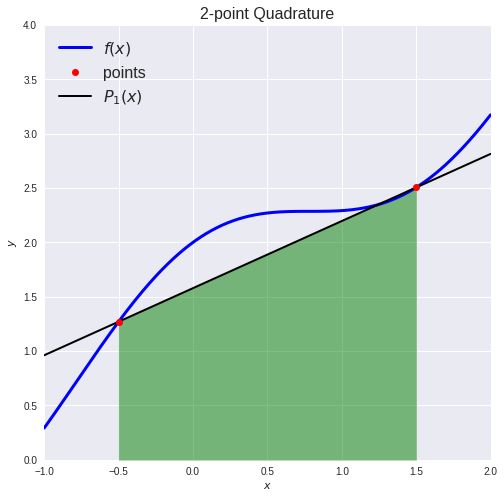

In [19]:
#Function
def f(x):
    return 1+np.cos(x)**2+x

#Quadrature with 2 points (Trapezoidal rule)
X = np.array([-0.5,1.5])
Ln=Quadrature( f, X, xmin=-1, xmax=2, ymin=0, ymax=4 )

In [20]:
integrate.quad(f,X[0],X[-1])

(4.245647748216942, 4.713615884518398e-14)

In [21]:
F(f,X)(1.5)-F(f,X)(-0.5)

3.775154904633847

In [22]:
integrate.quad(Ln,X[0],X[-1])[0]

3.775154904633847

### [Scipy implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.trapz.html#r78)

In [0]:
integrate.trapz?

In fact, as expected

In [0]:
Y=f(X)
integrate.trapz(Y,X)

3.7751549046338475

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/42/Composite_trapezoidal_rule_illustration.png/1200px-Composite_trapezoidal_rule_illustration.png" height="400" width="400">

For a better approximation we can use more intervals

In [0]:
x=np.linspace( X[0], X[-1], 1000 )
integrate.trapz(f(x),x)

4.2456474200304779

## Simpson's rule

A slightly better approximation to integration is the Simpson's rule. For this, assume a function $f(x)$ and an interval $[x_0,x_2]$, with a intermediate point $x_1$. The associate second-order Lagrange polynomial is given by: See previous [exercise](./interpolation.ipynb#Exercise-interpolation)

$$P_2(x) = \frac{(x-x_1)(x-x_2)}{(x_0-x_1)(x_0-x_2)}f(x_0) + \frac{(x-x_0)(x-x_2)}{(x_1-x_0)(x_1-x_2)}f(x_1) + \frac{(x-x_0)(x-x_1)}{(x_2-x_0)(x_2-x_1)}f(x_2)$$

The final expression is then:

$$\int_{x_0}^{x_2} f(x)dx = \frac{h}{3}[ f(x_0)+4f(x_1)+f(x_2) ]-\frac{h^5}{90}f^{(4)}(\xi)$$


poly1d([-0.3825737 ,  1.        ,  1.86579458])

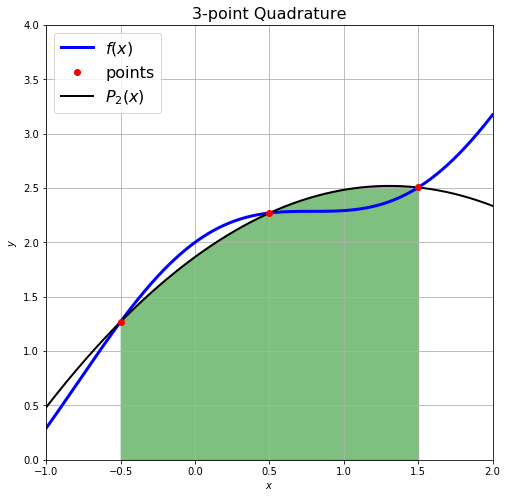

In [0]:
#Function
def f(x):
    return 1+np.cos(x)**2+x

#Quadrature with 3 points (Simpson's rule)
X = np.array([-0.5,0.5,1.5])
Ln=Quadrature( f, X, xmin=-1, xmax=2, ymin=0, ymax=4 )

In [0]:
integrate.quad(f,X[0],X[-1])[0]

4.245647748216942

In [0]:
integrate.quad(Ln,X[0],X[-1])[0]

4.285253172123376

### Scipy implementation
Improves with number of points:
![Simpons](https://upload.wikimedia.org/wikipedia/en/thumb/6/67/Simpsonsrule2.gif/220px-Simpsonsrule2.gif)

In [0]:
integrate.simps?

In [0]:
integrate.simps(Ln(X),X)

4.285253172123376

In [0]:
x=np.linspace( X[0], X[-1], 100000 )
integrate.trapz(f(x),x),integrate.simps(f(x),x)

(4.2456477481841874, 4.2456477482169408)

In [0]:
4.245647748216942

4.245647748216942

## <font color='red'>     **Activity** </font>

<font color='red'>   
- Using the trapezoidal and the Simpson's rules, determine the value of the integral (4.24565)

$$ \int_{-0.5}^{1.5}(1+\cos^2x + x)dx $$

- Take the previous routine Quadrature and the above function and explore high-order quadratures. What happends when you increase  the number of points?

N=20
def f(x):
    return 1+np.cos(x)**2+x

#Quadrature with N points (Simpson's rule)
X = np.array(np.linspace(-0.5,1.5,N))
Ln=Quadrature( f, X, xmin=-1, xmax=2, ymin=0, ymax=4 )
integrate.simps(Ln(X),X)
print(poly1d(Ln))

## <font color='red'>     **Activity** </font>

<font color='red'>  

Approximate the following integrals using formulas Trapezoidal and Simpson rules. Are the accuracies of
the approximations consistent with the error formulas? 

\begin{eqnarray*}
&\int_{0}^{0.1}&\sqrt{1+ x}dx \\
&\int_{0}^{\pi/2}&(\sin x)^2dx\\ 
&\int_{1.1}^{1.5}&e^xdx 
\end{eqnarray*}

# Composite Numerical Integration

Although above-described methods are good enough when we want to integrate along small intervals, larger intervals would require more sampling points, where the resulting Lagrange interpolant will be a high-order polynomial. These interpolant polynomials exihibit usually an oscillatory behaviour (best known as [Runge's phenomenon](http://en.wikipedia.org/wiki/Runge%27s_phenomenon)), being more inaccurate as we increase $n$.

An elegant and computationally inexpensive solution to this problem is a *piecewise* approach, where low-order Newton-Cotes formula (like trapezoidal and Simpson's rules) are applied over subdivided intervals. This methods are already implemented in the previous `scipy` trapezoidal and Simpsons implementations. An internal implementation is given in the [Appendix of integration](./Appendix.ipynb#composite-numerical integration), the _Composite Trapezoidal rule_ given by:

$$ \int_a^b f(x) dx = \frac{h}{2}\left[ f(a) + 2\sum_{j=1}^{N-1}f(x_j) + f(b) \right] - \frac{b-a}{12}h^2 f^{''}(\mu)$$

and the _Composite Simpson's rule_ given by

$$ \int_a^bf(x)dx = \frac{h}{3}\left[ f(a) +2 \sum_{j=1}^{(n/2)-1}f(x_{2j})+4\sum_{j=1}^{n/2}f(x_{2j-1})+f(b) \right] - \frac{b-a}{180}h^4f^{(4)}(\mu)$$

## Composite trapezoidal rule

This formula is obtained when we subdivide the integration interval $[a,b]$ within sets of two points, such that we can apply the previous Trapezoidal rule to each one.

Let $f(x)$ be a well behaved function ($f\in C^2[a,b]$), defining the interval space as $h = (b-a)/N$, where N is the number of intervals we take, the **Composite Trapezoidal rule** is given by:

$$ \int_a^b f(x) dx = \frac{h}{2}\left[ f(a) + 2\sum_{j=1}^{N-1}f(x_j) + f(b) \right] - \frac{b-a}{12}h^2 f^{''}(\mu)$$

for some value $\mu$ in $(a,b)$.

## <font color='red'>     **Activity** </font>

<font color='red'>   
Determine the value of the integral (4.24565)

$$ \int_{-0.5}^{1.5}(1+\cos^2x + x)dx $$

</font>

## <font color='red'>     **Activity** </font>

<font color='red'>    

An experiment has measured $dN(t)/dt$, the number of particles entering a counter, per unit time, as a function of time. Your problem is to integrate this spectrum to obtain the number of particles $N(1)$ that entered the counter
in the first second

$$ N(1) = \int_0^1 \frac{dN}{dt} dt$$

For the problem it is assumed exponential decay so that there actually is an analytic answer. 

$$ \frac{dN}{dt} = e^{-t} $$

Compare the relative error for the composite trapezoid and Simpson rules. Try different values of N. Make a logarithmic plot of N vs Error.

- - -

# Adaptive Quadrature Methods

Calculating the integrate of the function $f(x) = e^{-3x}\sin(4x)$ within the interval $[0,4]$, we obtain:

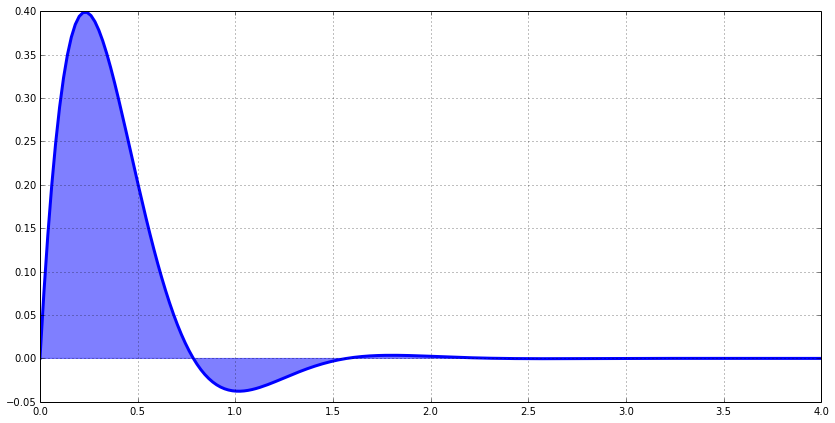

In [0]:
#Function
def f(x):
    return np.exp(-3*x)*np.sin(4*x)

#Plotting
X = np.linspace( 0, 4, 200 )
Y = f(X)
plt.figure( figsize=(14,7) )
plt.plot( X, Y, color="blue", lw=3 )
plt.fill_between( X, Y, color="blue", alpha=0.5 )
plt.xlim( 0,4 )
plt.grid()

Using composite numerical integration is not completely adequate for this problem as the function exhibits different behaviours for differente intervals. For the interval $[0,2]$ the function varies noticeably, requiring a rather small integration interval $h$. However, for the interval $[2,4]$ variations are not considerable and low-order composite integration is enough. This lays a pathological situation where simple composite methods are not efficient. In order to remedy this, we introduce an adaptive quadrature methods, where the integration step $h$ can vary according to the interval. The main advantage of this is a controlable precision of the result.

## Simpson's adaptive quadrature

Although adaptive quadrature can be readily applied to any quadrature method, we illustrate the method with  the Simpson's adaptive quadrature.

Let's assume a function $f(x)$. We want to compute the integral within the interval $[a,b]$. Using a simple Simpson's quadrature, we obtain:

$$\int_a^bf(x)dx = S(a,b) - \frac{h^5}{90}f^{(4)}(\xi)$$

where we introduce the notation:

$$S(a,b) = \frac{h}{3}\left[ f(a) + 4f(a+h) + f(b) \right]$$

and $h$ is simply $h = (b-a)/2$.

![](https://raw.githubusercontent.com/sbustamante/ComputationalMethods/bb0f137366b3d2bbfdd33425ad78be4003716703/material/figures/adaptive_quadrature.png)

Now, instead of using an unique Simpson's quadrature, we implement two, by adding a new point in the midle of the interval $[a,b]$, $(a+b)/2$, yielding:

$$\int_a^bf(x)dx = S\left(a,\frac{a+b}{2}\right) + S\left(\frac{a+b}{2},b\right) - \frac{1}{16}\left(\frac{h^5}{90}\right)f^{(4)}(\xi)$$

For this expression, we reasonably assume an equal fourth-order derivative $f^{(4)}(\xi) = f^{(4)}(\xi_1) = f^{(4)}(\xi_2) $, where $\xi_1$ is the estimative for the first subtinterval (i.e. $\xi_1\in[a,(a+b)/2]$), and $\xi_2$ for the second one (i.e. $\xi_1\in[(a+b)/2, b]$).

As both expressions can approximate the real value of the integrate, we can equal them, obtaining:

$$
\int_a^bf(x)dx \begin{cases} \sim S(a,b) - \frac{h^5}{90}f^{(4)}(\xi)\\ 
\approx S\left(a,\frac{a+b}{2}\right) + S\left(\frac{a+b}{2},b\right) - \frac{1}{16}\left(\frac{h^5}{90}\right)f^{(4)}(\xi)\\
\end{cases}
$$

which leads us to a simple way to estimate the error without knowing the fourth-order derivative, i.e.

$$\frac{h^5}{90}f^{(4)}(\xi) = \frac{16}{15}\left| S(a,b) - S\left(a,\frac{a+b}{2}\right) - S\left(\frac{a+b}{2},b\right) \right|$$

If we fix a precision $\epsilon$, such that the obtained error for the second iteration is smaller

$$\frac{1}{16}\frac{h^5}{90}f^{(4)}(\xi) < \epsilon $$

it implies:

$$\left| S(a,b) - S\left(a,\frac{a+b}{2}\right) - S\left(\frac{a+b}{2},b\right) \right|< 15 \epsilon$$

and 

$$\left| \int_a^bf(x) dx- S\left(a,\frac{a+b}{2}\right) - S\left(\frac{a+b}{2},b\right) \right|< \epsilon$$

The second iteration is then $15$ times more precise than the first one.

## Steps Simpson's adaptive quadrature

**1.** Give the function $f(x)$ to be integrated, the inverval $[a,b]$ and set a desired precision $\epsilon$.

**2.** Compute the next Simpsons's quadratures:

$$ S(a,b),\ S\left(a,\frac{a+b}{2}\right),\ S\left(\frac{a+b}{2},b\right) $$

**3.** If 

$$\frac{1}{15}\left| S(a,b) - S\left(a,\frac{a+b}{2}\right) - S\left(\frac{a+b}{2},b\right) \right|<\epsilon$$

then the integration is ready and is given by:

$$\int_a^bf(x) dx \approx S\left(a,\frac{a+b}{2}\right) + S\left(\frac{a+b}{2},b\right) $$

within the given precision.

**4.** If the previous step is not fulfilled, repeat from step **2** using as new intervals $[a,(a+b)/2]$ and $[(a+b)/2,b]$ and a new precision $\epsilon_1 = \epsilon/2$. Repeating until step 3 is fulfilled for all the subintervals.

## <font color='red'>     **Activity** </font>

###Models of Universe

From the Friedmann equations can be found the dynamics of the Universe, i.e., the evolution of the expansion with time that depends on the content of matter and energy of the Universe. Before introducing the general expression, there are several quatities that need to be defined. 

It is convenient to express the density in terms of a critical density $\rho_c$ given by

\begin{equation}
\rho_c = 3H_0^2/8\pi G
\end{equation}

where $H_o$ is the Hubble constant. The critical density is the density needed in order the Universe to be flat. To obtained it, it is neccesary to make the curvature of the universe $\kappa = 0$. The critical density is one value per
time and the geometry of the universe depends on this value, or equally on $\kappa$. For a universe with $\kappa<0$ it would ocurre a big crunch(closed universe) and for a $\kappa>0$ there would be an open universe.    

Now, it can also be defined a density parameter, $\Omega$, a normalized density

\begin{equation}
\Omega_{i,0} = \rho_{i,0}/\rho_{crit}
\end{equation}

where $\rho_{i,0}$ is the actual density($z=0$) for the component $i$. Then, it can be found the next expression 

\begin{equation}
\frac{H^2(t)}{H_{0}^{2}} = (1-\Omega_0)(1+z)^2 + \Omega_{m,0}(1+z^3)+ \Omega_{r,0}(1+z)^4 + \Omega_{\Lambda,0}
\end{equation}

where $\Omega_{m,0}$, $\Omega_{r,0}$ and  $\Omega_{\Lambda,0}$ are the matter, radiation and vacuum density parameters. And $\Omega_0$ is the total density including the vacuum energy. 

This expression can also be written in terms of the expansion or scale factor, $a$, by using: 

$$1+z = 1/a$$

For the next universe models, plot time($H_{0}^{-1}$ units) vs the scale factor:

-Einstein-de Sitter Universe: Flat space, null vacuum energy and dominated by matter

\begin{equation}
t = H_0^{-1} \int_0^{a'} a^{1/2}da
\end{equation}
 
-Radiation dominated universe: All other components are not contributing 

$$
t = H_0^{-1} \int_0^{a'} \frac{a}{[\Omega_{r,0}+a^2(1-\Omega_{r,0})]^{1/2}}da
$$

-WMAP9 Universe 

\begin{equation}
t = H_0^{-1} \int_0^{a'} \left[(1-\Omega_{0})+ \Omega_{M,0}a^{-1} + \Omega_{R,0}a^{-2} +\Omega_{\Lambda,0}a^2\right]^{-1/2} da
\end{equation}


You can take the cosmological parameters  from the link 

http://lambda.gsfc.nasa.gov/product/map/dr5/params/lcdm_wmap9.cfm or use these ones: $\Omega_M = 0.266$,
$\Omega_R = 8.24\times 10^{-5}$ and $\Omega_\Lambda = 0.734$. 

Use composite Simpson's rule to integrate and compare it with the analytical expression in case you can get it. 
The superior limit in the integral corresponds to the actual redshift $z=0$. What is happening to our universe? 


## <font color='red'>     **Activity** </font>

<font color='red'>   
- Using the Simpson's adaptive quadrature determine the value of the next integral with a precision of float32.

$$\int_0^4 e^{-3x}\sin(4x)dx$$


## <font color='red'>     **Activity** </font>

<font color='red'>   
Fresnel integrals are commonly used in the study of light difraction at a rectangular aperture, they are given by:

$$c(t) = \int_0^t\cos\left(\frac{\pi}{2}\omega^2\right)d\omega$$

$$s(t) = \int_0^t\sin\left(\frac{\pi}{2}\omega^2\right)d\omega$$

These integrals cannot be solved using analitical methods. Using the previous routine for adaptive quadrature, compute the integrals with a precision of $\epsilon=10^{-4}$ for values of $t=0.1,0.2,0.3,\cdots 1.0$. Create two arrays with those values and then make a plot of $c(t)$ vs $s(t)$. The resulting figure is called Euler spiral, that is a member of a family of curves called [Clothoid loops](http://en.wikipedia.org/wiki/Vertical_loop).


- - -

# Improper Integrals

Improper integral can be processed with the `quad` function of `scipy.integrate`, or other integration functions, by using the infinity implementation of `numpy`, (which is the same of the `math` module, see below)
* Positive infinity: `np.inf` and several aliases
* Negagite infinity: `np.NINF`
For details of the implementation and the aliases [see here](https://stackoverflow.com/a/42315752/2268280)

In [0]:
import numpy as np

In [0]:
float('inf')

inf

In [0]:
np.inf == float('inf')

True

There are also function to check for infinity numbers:

In [0]:
np.isfinite(2)

True

In [0]:
np.isfinite(np.inf)

False

In [0]:
np.isfinite(2),np.isinf(np.inf)

(True, True)

So it is possible to evaluate improper integrals like

$$
\int_1^\infty x^{-2}\,\operatorname{d}x=1\,.
$$

In [0]:
integrate.quad(lambda x: 1/x**2,1,np.inf)

(1.0, 1.1102230246251565e-14)

or
$$
\int_{-\infty}^\infty \operatorname{e}^{x^{-2}}\,\operatorname{d}x=\sqrt{\pi},.
$$

In [0]:
integrate.quad(lambda x: np.exp(-x**2),np.NINF,np.inf)

(1.7724538509055159, 1.4202636780944923e-08)

In [0]:
np.sqrt(np.pi)

1.7724538509055159

In [0]:
np.sqrt(np.pi)/2.

0.88622692545275794

In [0]:
integrate.quad(lambda x: np.exp(-x**2),0,np.inf)

(0.8862269254527579, 7.101318390472462e-09)

Although the previous integration methods can be applied in almost every situation, improper integrals pose a challenger to numerical methods as they involve indeterminations and infinite intervals. Next, we shall cover some tricks to rewrite improper integrals in terms of simple ones. See for example [here](https://stackoverflow.com/q/30769913/2268280)

## Left endpoint singularity

Assuming a function $f(x)$ such that it can be rewritten as

$$ f(x) = \frac{g(x)}{(x-a)^p} $$

the integral over an interval $[a,b]$ converges only and only if $0<p<1$.

Using Simpson's composite rule, it is possible to compute the fourth-order Taylor polynomial of the function $g(x)$ at the point $a$, obtaining

$$ P_4(x) = g(a) + g^{'}(a)(x-a)+\frac{g^{''}(a)}{2!}(x-a)^2 +\frac{g^{''}(a)}{3!}(x-a)^3+ \frac{g^{(4)}(a)}{4!}(x-a)^4$$

The integral can be then calculated as

$$\int_a^b f(x)dx = \int_a^b\frac{g(x)-P_4(x)}{(x-a)^p}dx + \int_a^b\frac{P_4(x)}{(x-a)^p}dx$$

The second term is an integral of a polynimal, which can be easily integrated using analytical methods.

The first term is no longer pathologic as there is not any indetermination, and it can be determined using composite Simpson's rule

## Right endpoint singularity

This is the contrary case, where the indetermination is present in the extreme $b$ of the integration interval $[a,b]$. For this problem is enough to make a variable substitution

$$ z=-x \  \ \ \ \ \  dz=-dx$$

With this, the right endpoint singularity becomes a left endpoint singularity and the previous method can be directly applied.

## Infinite singularity

Finally, infinite singularities are those where the integration domain is infinite, i.e.

$$\int_a^\infty f(x)dx$$

this type of integrals can be easily turned into a left endpoint singularity jus making the next variable substitution

$$t = x^{-1}\ \ \ \ \ dt = -x^{-2}dx$$

yielding

$$ \int_a^\infty f(x)dx = \int_0^{1/a}t^{-2}f\left(\frac{1}{t}\right)dt $$

## <font color='red'>     **Activity** </font>

<font color='red'>   
Error function is a special and non-elementary function that is widely used in probability, statistics and diffussion processes.
It is defined through the integral:

$$\mbox{erf}(x) = \frac{2}{\sqrt{\pi}}\int_0^x e^{-t^2}dt$$

Using the substitution $u=t^2$ it is possible to use the previous methods for impropers integrals in order to evaluate the error function. Create a routine called `ErrorFunction` that, given a value of $x$, return the respective value of the integral.


\begin{equation}
a=1 \label{a}
\end{equation}
\ref{a}

- - -